<a href="https://colab.research.google.com/github/pray-ash911/Twitter-sentiment-analysis/blob/main/Copy_of_Sentiment_analysis_using_two_diff_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 1: SETUP AND INSTALLATION


In [ ]:
# Install required libraries
!pip install transformers datasets torch scikit-learn matplotlib seaborn wordcloud pandas numpy nltk kagglehub -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import os
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score

# Deep Learning libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Text preprocessing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Visualization
from wordcloud import WordCloud

print(" All libraries imported successfully!")

# Download ALL required NLTK data
print("\ Downloading NLTK data files...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-eng', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("NLTK data downloaded successfully!")

<>:40: SyntaxWarning: invalid escape sequence '\ '
<>:40: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-3882571386.py:40: SyntaxWarning: invalid escape sequence '\ '
  print("\ Downloading NLTK data files...")


 All libraries imported successfully!
\ Downloading NLTK data files...
NLTK data downloaded successfully!


[nltk_data] Error loading omw-eng: Package 'omw-eng' not found in
[nltk_data]     index


# PART 2: DATASET LOADING

In [ ]:
print(" Downloading Sentiment140 dataset from Kaggle...")

import kagglehub

# Download dataset
path = kagglehub.dataset_download("kazanova/sentiment140")
print(f"Dataset downloaded to: {path}")

# Find the CSV file in the downloaded directory
csv_path = None
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            csv_path = os.path.join(root, file)
            print(f"Found CSV file: {csv_path}")
            break
    if csv_path:
        break

# Load the dataset
df = pd.read_csv(csv_path,
                 encoding='latin-1',
                 header=None,
                 names=['target', 'id', 'date', 'flag', 'user', 'text'])

print(f" Dataset loaded successfully → {df.shape[0]:,} tweets")
print(f"   Columns: {list(df.columns)}")

# Rename 'target' to 'label' for consistency
df = df.rename(columns={'target': 'label'})

# Convert labels: 0=negative, 4=positive → 0=negative, 1=positive
df['label'] = df['label'].map({0: 0, 4: 1})

# Display dataset info
print("\n Dataset Information:")
print(f"   Total samples: {len(df):,}")
print(f"   Positive tweets (1): {df['label'].sum():,}")
print(f"   Negative tweets (0): {len(df) - df['label'].sum():,}")
print(f"   Class balance: {(df['label'].sum() / len(df) * 100):.1f}% positive")

# Show first few samples
print("\n Sample tweets:")
print(df.head())

# Display unique values in each column
print("Unique values in each column:")
print("="*50)
for column in df.columns:
    unique_vals = df[column].unique()
    print(f"\n{column}: {len(unique_vals)} unique values")
    if len(unique_vals) <= 10:
        print(f"  {unique_vals}")
    else:
        print(f"  First 5: {unique_vals[:5]}")

Using Colab cache for faster access to the 'sentiment140' dataset.
Dataset downloaded to: /kaggle/input/sentiment140
Found CSV file: /kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
 Dataset loaded successfully → 1,600,000 tweets
   Columns: ['target', 'id', 'date', 'flag', 'user', 'text']

 Dataset Information:
   Total samples: 1,600,000
   Positive tweets (1): 800,000
   Negative tweets (0): 800,000
   Class balance: 50.0% positive

 Sample tweets:
   label          id                          date      flag             user  \
0      0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3      0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4      0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                     

# PART 3: TEXT PREPROCESSING CLASS


In [ ]:

class TextPreprocessor:
    """Class for comprehensive text preprocessing"""

    def __init__(self):
        try:
            self.stop_words = set(stopwords.words('english'))
            self.stemmer = PorterStemmer()
            self.lemmatizer = WordNetLemmatizer()
        except:
            # Fallback if NLTK data not loaded
            self.stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
                                  "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
                                  'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
                                  'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
                                  'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
                                  'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
                                  'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
                                  'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
                                  'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
                                  'with', 'about', 'against', 'between', 'into', 'through', 'during',
                                  'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in',
                                  'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
                                  'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
                                  'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no',
                                  'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                                  's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",
                                  'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't",
                                  'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',
                                  'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan',
                                  "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                                  'won', "won't", 'wouldn', "wouldn't"])
            self.stemmer = None
            self.lemmatizer = None

    def clean_text(self, text):
        """Basic text cleaning: remove URLs, mentions, special chars"""
        if not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)

        # Remove special characters and digits (keep basic punctuation)
        text = re.sub(r'[^a-zA-Z\s.!?,]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_text(self, text):
        """Tokenization using simple split (fallback if NLTK fails)"""
        try:
            return word_tokenize(text)
        except:
            # Fallback to simple split
            return text.split()

    def remove_stopwords(self, tokens):
        """Remove stop words from tokenized text"""
        return [word for word in tokens if word not in self.stop_words]

    def apply_stemming(self, tokens):
        """Apply Porter Stemmer to tokens"""
        if self.stemmer:
            return [self.stemmer.stem(word) for word in tokens]
        return tokens

    def apply_lemmatization(self, tokens):
        """Apply WordNet Lemmatizer to tokens"""
        if self.lemmatizer:
            return [self.lemmatizer.lemmatize(word) for word in tokens]
        return tokens

    def full_preprocessing(self, text, use_lemmatization=True):
        """Complete preprocessing pipeline"""
        # Clean text
        text = self.clean_text(text)

        # Tokenize
        tokens = self.tokenize_text(text)

        # Remove stopwords
        tokens = self.remove_stopwords(tokens)

        # Apply stemming or lemmatization
        if use_lemmatization and self.lemmatizer:
            tokens = self.apply_lemmatization(tokens)
        elif self.stemmer:
            tokens = self.apply_stemming(tokens)

        # Join back to string
        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing to a sample for demonstration
print("\n Text Preprocessing Examples:")
print("-" * 50)

sample_texts = df['text'].head(3).tolist()
for i, text in enumerate(sample_texts):
    print(f"\nExample {i+1}:")
    print(f"Original: {text[:100]}...")
    cleaned = preprocessor.clean_text(text)
    print(f"Cleaned:  {cleaned[:100]}...")

    # Tokenized
    tokens = preprocessor.tokenize_text(cleaned)
    print(f"Tokenized: {tokens[:10]}...")

    # Without stopwords
    filtered = preprocessor.remove_stopwords(tokens)
    print(f"No Stopwords: {filtered[:10]}...")

    # Lemmatized
    lemmatized = preprocessor.apply_lemmatization(filtered)
    print(f"Lemmatized: {lemmatized[:10]}...")

# Preprocess entire dataset
print("\n Applying preprocessing to dataset...")
df['cleaned_text'] = df['text'].apply(lambda x: preprocessor.full_preprocessing(str(x), use_lemmatization=True))
print(f" Preprocessing completed! Column 'cleaned_text' added.")


 Text Preprocessing Examples:
--------------------------------------------------

Example 1:
Original: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third D...
Cleaned:  a thats a bummer. you shoulda got david carr of third day to do it. d...
Tokenized: ['a', 'thats', 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr']...
No Stopwords: ['thats', 'bummer', '.', 'shoulda', 'got', 'david', 'carr', 'third', 'day', '.']...
Lemmatized: ['thats', 'bummer', '.', 'shoulda', 'got', 'david', 'carr', 'third', 'day', '.']...

Example 2:
Original: is upset that he can't update his Facebook by texting it... and might cry as a result  School today ...
Cleaned:  is upset that he cant update his facebook by texting it... and might cry as a result school today al...
Tokenized: ['is', 'upset', 'that', 'he', 'cant', 'update', 'his', 'facebook', 'by', 'texting']...
No Stopwords: ['upset', 'cant', 'update', 'facebook', 'texting', '...', 'might', 'cry'

# PART 4: DATA VISUALIZATION


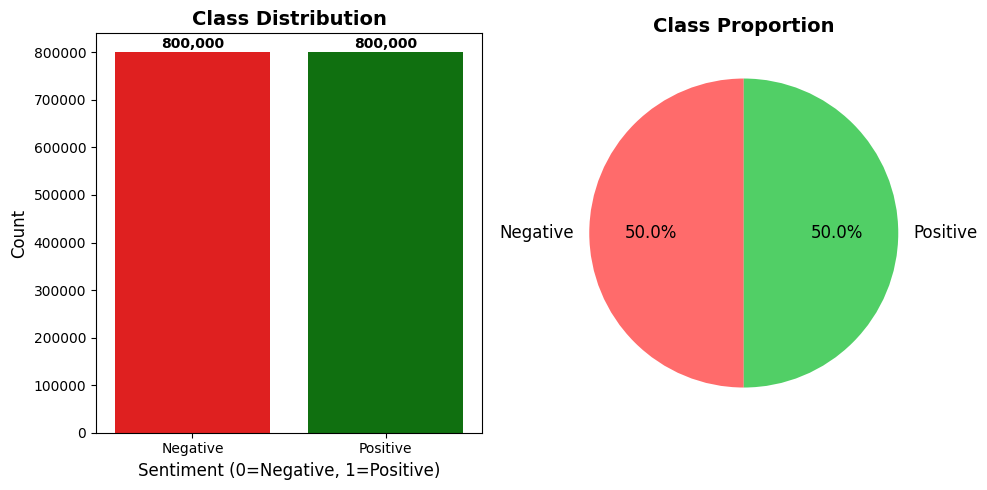

In [ ]:

# VISUALIZATION 1: Class Distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df, palette=['red', 'green'])
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Negative', 'Positive'])

# Add count labels on bars
for i, count in enumerate(df['label'].value_counts().sort_index()):
    plt.text(i, count + 10000, f'{count:,}', ha='center', fontweight='bold')

plt.subplot(1, 2, 2)
# Pie chart for class distribution
class_counts = df['label'].value_counts()
colors = ['#ff6b6b', '#51cf66']
plt.pie(class_counts, labels=['Negative', 'Positive'], autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 12})
plt.title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

 Generating word clouds...


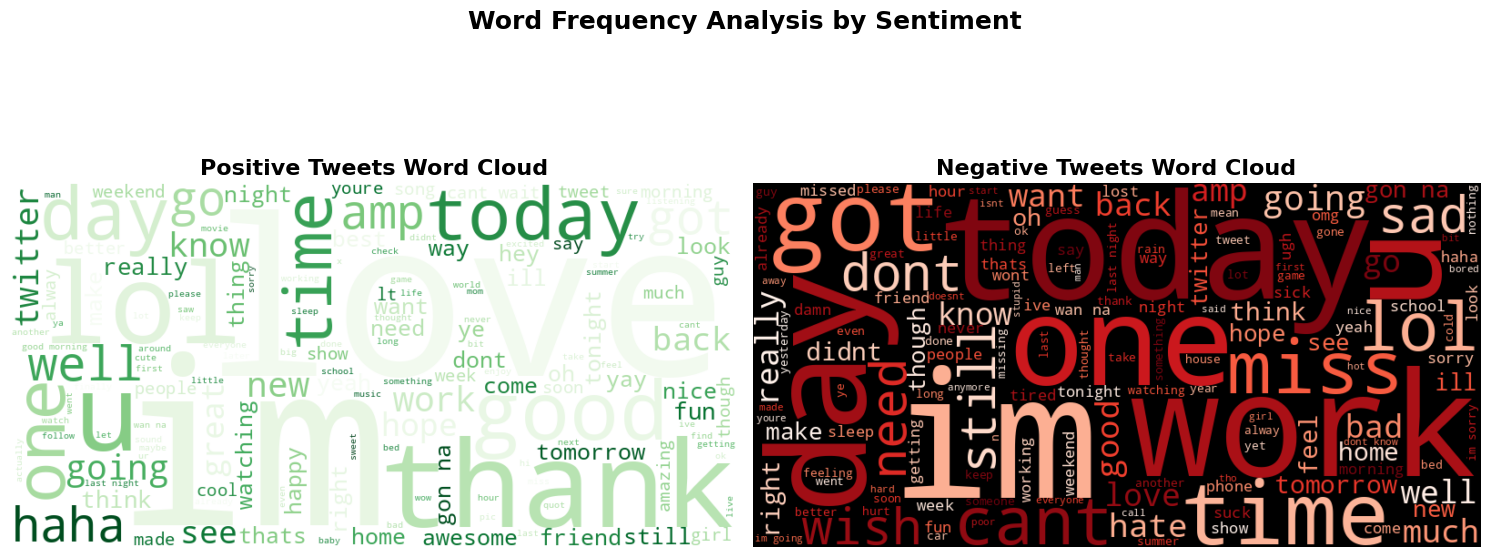

Word clouds generated successfully!


In [ ]:
# VISUALIZATION 2: Word Clouds
print(" Generating word clouds...")

sample_size = 20000
positive_sample = df[df['label'] == 1].sample(n=min(sample_size, sum(df['label'] == 1)), random_state=42)
negative_sample = df[df['label'] == 0].sample(n=min(sample_size, sum(df['label'] == 0)), random_state=42)

positive_text = " ".join(positive_sample['cleaned_text'].astype(str).values)
negative_text = " ".join(negative_sample['cleaned_text'].astype(str).values)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400,
                               background_color='white',
                               colormap='Greens',
                               max_words=150).generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Tweets Word Cloud', fontsize=16, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400,
                               background_color='black',
                               colormap='Reds',
                               max_words=150).generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Tweets Word Cloud', fontsize=16, fontweight='bold')
plt.axis('off')

plt.suptitle('Word Frequency Analysis by Sentiment', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

print("Word clouds generated successfully!")

# PART 5: DATA PREPARATION


In [ ]:
print("\n Preparing balanced training dataset...")

# For faster training, sample 20k from each class
sample_per_class = 20000
positive_tweets = df[df['label'] == 1].sample(n=sample_per_class, random_state=42)
negative_tweets = df[df['label'] == 0].sample(n=sample_per_class, random_state=42)

# Combine and shuffle
balanced_data = pd.concat([positive_tweets, negative_tweets]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset created: {len(balanced_data):,} tweets")
print(f"   Positive: {sum(balanced_data['label'] == 1):,}")
print(f"   Negative: {sum(balanced_data['label'] == 0):,}")

# Split into train and test sets
train_df, test_df = train_test_split(balanced_data,
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=balanced_data['label'])

print(f"\n Train-Test Split:")
print(f"   Training samples: {len(train_df):,}")
print(f"   Testing samples:  {len(test_df):,}")
print(f"   Train positive: {sum(train_df['label'] == 1):,}")
print(f"   Train negative: {sum(train_df['label'] == 0):,}")


 Preparing balanced training dataset...
Balanced dataset created: 40,000 tweets
   Positive: 20,000
   Negative: 20,000

 Train-Test Split:
   Training samples: 32,000
   Testing samples:  8,000
   Train positive: 16,000
   Train negative: 16,000


# IMPROVED TF-IDF + LOGISTIC REGRESSION FOR HIGHER ACCURACY


In [ ]:
print("MODEL 1: LOGISTIC REGRESSION WITH TF-IDF")

# Step 1: Improved TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,   # increased vocabulary
    stop_words='english',
    ngram_range=(1, 3),   # include trigrams for better context
    min_df=3,             # include more rare but meaningful words
    max_df=0.9            # include more frequent words
)

# Step 2: Transform text to TF-IDF features
print("Transforming text to improved TF-IDF features...")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Testing features shape:  {X_test_tfidf.shape}")

# Step 3: Train Logistic Regression

# ATTEMPT 1:
'''
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=100,
    solver='lbfgs',
    class_weight='balanced',
    tol=1e-1
)'''

# ATTEMPT 2:

lr_model = LogisticRegression(
    max_iter=2000,            # Ensure model convergence
    random_state=42,          # Reproducibility
    C=2.0,
    solver='lbfgs',           # Optimization algorithm
    class_weight='balanced'   # Handle class imbalance
)

print("\nTraining Improved Logistic Regression classifier...")
lr_model.fit(X_train_tfidf, train_df['label'])
print(" Improved Logistic Regression training completed!")

# Step 4: Make predictions
y_pred_lr = lr_model.predict(X_test_tfidf)
y_prob_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

# Step 5: Evaluate model
print("\n Improved Logistic Regression Evaluation:")
print("-" * 40)
print("Accuracy:", accuracy_score(test_df['label'], y_pred_lr))
print("\nDetailed Classification Report:")
print(classification_report(test_df['label'], y_pred_lr, target_names=['Negative', 'Positive']))

MODEL 1: LOGISTIC REGRESSION WITH TF-IDF
Transforming text to improved TF-IDF features...
Training features shape: (32000, 10000)
Testing features shape:  (8000, 10000)

Training Improved Logistic Regression classifier...
 Improved Logistic Regression training completed!

 Improved Logistic Regression Evaluation:
----------------------------------------
Accuracy: 0.7465

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.73      0.74      4000
    Positive       0.74      0.76      0.75      4000

    accuracy                           0.75      8000
   macro avg       0.75      0.75      0.75      8000
weighted avg       0.75      0.75      0.75      8000



# PART 7: MODEL 2 - DISTILBERT


In [ ]:
print("MODEL 2: DISTILBERT TRANSFORMER MODEL")

# Step 1: Load pre-trained DistilBERT
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

print(f" Loaded: {model_name}")
print(f"   Model parameters: {model.num_parameters():,}")

# Step 2: Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Step 3: Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Apply tokenization
print("\n Tokenizing datasets...")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
print(" Tokenization completed!")

# Step 4: Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, output_dict=True, zero_division=0)

    return {
        'accuracy': accuracy,
        'f1': report['weighted avg']['f1-score'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall']
    }

# Step 5: Training arguments
# ATTEMPT 1:
'''
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    num_train_epochs=1,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=1e-3,
    weight_decay=0.001,
    eval_strategy="no",
    save_strategy="epoch",
    load_best_model_at_end=False,
    metric_for_best_model="accuracy",
    fp16=False,
    report_to="none",
    logging_steps=500,
    save_total_limit=1,
    warmup_ratio=0.0,
    gradient_accumulation_steps=1,
    adam_epsilon=1e-6,
    max_grad_norm=10.0
)'''

# ATTEMPT 2:
# DistilBERT Training Configuration
training_args = TrainingArguments(
    output_dir="./distilbert_results",    # Save checkpoints
    num_train_epochs=3,                   # Training epochs
    per_device_train_batch_size=16,       # Train batch size
    per_device_eval_batch_size=32,
    learning_rate=2e-5,                   # Fine-tuning learning rate
    weight_decay=0.01,                    # Regularization
    eval_strategy="epoch",
    save_strategy="epoch",                # Save each epoch
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",     # Selection metric
    fp16=True,                            # Mixed precision
    report_to="none",
    logging_steps=50,                     # Log frequency
    save_total_limit=2                    # Limit checkpoints
)


# Step 6: Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

# Step 7: Train the model
print("\n Training DistilBERT (this may take 10-15 minutes)...")
trainer.train()
print(" DistilBERT training completed!")

# Step 8: Evaluate DistilBERT
print("\n DistilBERT Evaluation:")
print("-" * 40)

bert_results = trainer.evaluate()
print("Performance Metrics:")
for key, value in bert_results.items():
    if 'eval_' in key:
        metric_name = key.replace('eval_', '').replace('_', ' ').title()
        print(f"  {metric_name}: {value:.4f}")

# Get predictions
bert_predictions = trainer.predict(tokenized_test)
y_pred_bert = np.argmax(bert_predictions.predictions, axis=1)
y_prob_bert = torch.softmax(torch.tensor(bert_predictions.predictions), dim=1)[:, 1].numpy()

MODEL 2: DISTILBERT TRANSFORMER MODEL


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Loaded: distilbert-base-uncased
   Model parameters: 66,955,010

 Tokenizing datasets...


Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

 Tokenization completed!

 Training DistilBERT (this may take 10-15 minutes)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.382000,0.409421,0.814125,0.813462,0.818656,0.814125
2,0.311200,0.410479,0.822625,0.822568,0.823038,0.822625
3,0.201000,0.506935,0.821375,0.821342,0.821614,0.821375


 DistilBERT training completed!

 DistilBERT Evaluation:
----------------------------------------


Performance Metrics:
  Loss: 0.4105
  Accuracy: 0.8226
  F1: 0.8226
  Precision: 0.8230
  Recall: 0.8226
  Runtime: 6.9068
  Samples Per Second: 1158.2770
  Steps Per Second: 36.1960


# PART 8: MODEL EVALUATION and VISUALIZATION


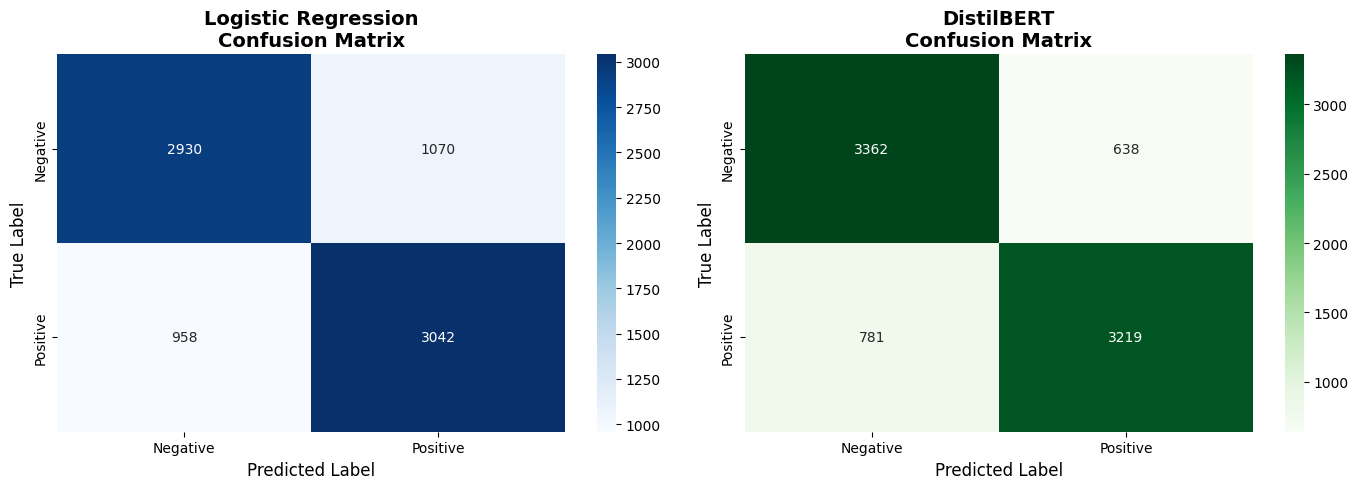


 Performance Metrics Comparison:
------------------------------------------------------------
              Model  Accuracy  F1-Score  Precision   Recall
Logistic Regression  0.746500  0.750000   0.739786 0.760500
         DistilBERT  0.822625  0.822568   0.823038 0.822625


In [ ]:
lr_accuracy = accuracy_score(test_df['label'], y_pred_lr)

# VISUALIZATION 3: Confusion Matrices Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(test_df['label'], y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=axes[0])
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# DistilBERT Confusion Matrix
cm_bert = confusion_matrix(test_df['label'], y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=axes[1])
axes[1].set_title('DistilBERT\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()


# VISUALIZATION 5: Model Performance Comparison
lr_f1 = f1_score(test_df['label'], y_pred_lr)
lr_precision = precision_score(test_df['label'], y_pred_lr)
lr_recall = recall_score(test_df['label'], y_pred_lr)

bert_accuracy = bert_results['eval_accuracy']
bert_f1 = bert_results['eval_f1']
bert_precision = bert_results['eval_precision']
bert_recall = bert_results['eval_recall']

comparison_data = {
    'Model': ['Logistic Regression', 'DistilBERT'],
    'Accuracy': [lr_accuracy, bert_accuracy],
    'F1-Score': [lr_f1, bert_f1],
    'Precision': [lr_precision, bert_precision],
    'Recall': [lr_recall, bert_recall]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n Performance Metrics Comparison:")
print("-" * 60)
print(comparison_df.to_string(index=False))

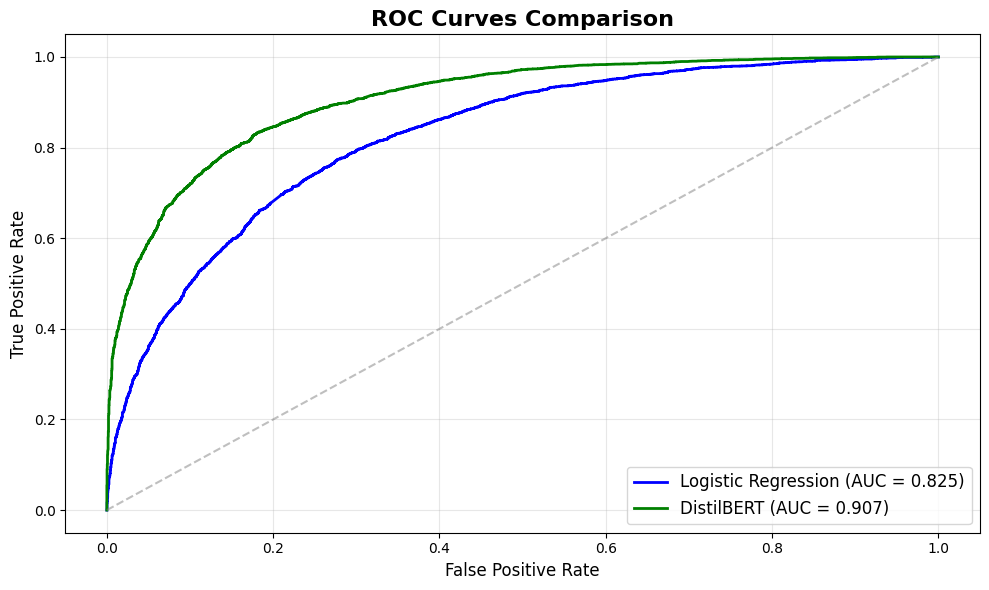

In [ ]:
# VISUALIZATION 4: ROC Curves Comparison
plt.figure(figsize=(10, 6))

# ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(test_df['label'], y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2,
         label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')

# ROC Curve for DistilBERT
fpr_bert, tpr_bert, _ = roc_curve(test_df['label'], y_prob_bert)
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, color='green', lw=2,
         label=f'DistilBERT (AUC = {roc_auc_bert:.3f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PART 9: FEATURE IMPORTANCE ANALYSIS


In [ ]:
print("FEATURE IMPORTANCE ANALYSIS (Logistic Regression)")

# Get feature names and coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Get top 10 positive and negative features
top_positive_idx = np.argsort(coefficients)[-10:][::-1]
top_negative_idx = np.argsort(coefficients)[:10]

print("\n Top 10 Words for POSITIVE Sentiment:")
print("-" * 40)
for idx in top_positive_idx:
    print(f"  {feature_names[idx]:<20} : {coefficients[idx]:.4f}")

print("\n Top 10 Words for NEGATIVE Sentiment:")
print("-" * 40)
for idx in top_negative_idx:
    print(f"  {feature_names[idx]:<20} : {coefficients[idx]:.4f}")

FEATURE IMPORTANCE ANALYSIS (Logistic Regression)

 Top 10 Words for POSITIVE Sentiment:
----------------------------------------
  thank                : 4.8877
  thanks               : 4.8601
  yay                  : 3.5367
  welcome              : 3.5295
  excited              : 3.5151
  awesome              : 3.4921
  wish luck            : 3.1510
  great                : 3.1379
  smile                : 2.9754
  love                 : 2.9623

 Top 10 Words for NEGATIVE Sentiment:
----------------------------------------
  sad                  : -8.8797
  sick                 : -5.6478
  wish                 : -5.5571
  miss                 : -4.9145
  missing              : -4.7756
  hurt                 : -4.7083
  hate                 : -4.3885
  poor                 : -4.3780
  broken               : -4.2431
  gutted               : -4.2192


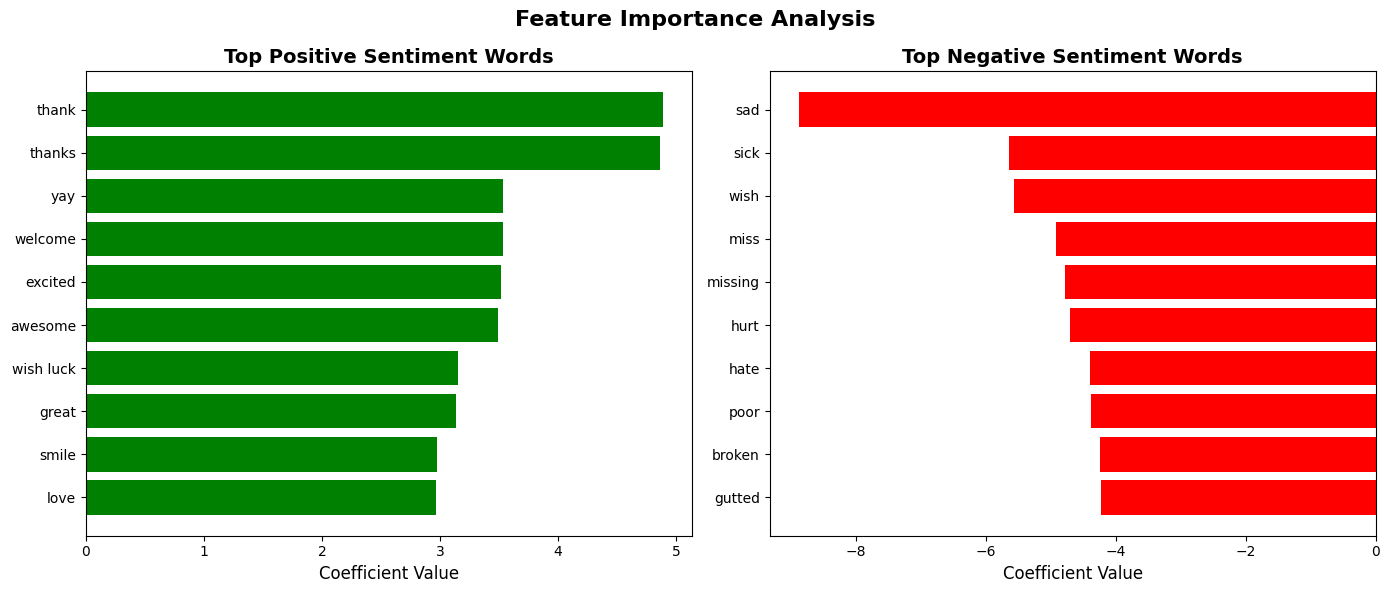

In [ ]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Positive words
pos_words = [feature_names[i] for i in top_positive_idx]
pos_scores = [coefficients[i] for i in top_positive_idx]
bars1 = ax1.barh(pos_words, pos_scores, color='green')
ax1.set_title('Top Positive Sentiment Words', fontsize=14, fontweight='bold')
ax1.set_xlabel('Coefficient Value', fontsize=12)
ax1.invert_yaxis()

# Negative words
neg_words = [feature_names[i] for i in top_negative_idx]
neg_scores = [coefficients[i] for i in top_negative_idx]
bars2 = ax2.barh(neg_words, neg_scores, color='red')
ax2.set_title('Top Negative Sentiment Words', fontsize=14, fontweight='bold')
ax2.set_xlabel('Coefficient Value', fontsize=12)
ax2.invert_yaxis()

plt.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# PART 10: TESTING WITH CUSTOM EXAMPLES


In [ ]:
print("TESTING WITH CUSTOM EXAMPLES")

def predict_sentiment(text, model_type='both'):
    results = {}

    # Logistic Regression prediction
    if model_type in ['lr', 'both']:
        cleaned_text = preprocessor.full_preprocessing(text, use_lemmatization=True)
        text_tfidf = tfidf_vectorizer.transform([cleaned_text])
        lr_pred = lr_model.predict(text_tfidf)[0]
        lr_prob = lr_model.predict_proba(text_tfidf)[0][lr_pred]
        results['Logistic Regression'] = {
            'sentiment': 'Positive' if lr_pred == 1 else 'Negative',
            'confidence': lr_prob,
            'prediction': lr_pred
        }

    # DistilBERT prediction
    if model_type in ['bert', 'both']:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            bert_probs = torch.softmax(outputs.logits, dim=1)
            bert_pred = torch.argmax(bert_probs, dim=1).item()
            bert_conf = bert_probs[0][bert_pred].item()

        results['DistilBERT'] = {
            'sentiment': 'Positive' if bert_pred == 1 else 'Negative',
            'confidence': bert_conf,
            'prediction': bert_pred
        }

    return results

# Test examples
test_examples = [
    "I love this product! It's absolutely amazing and works perfectly!",
    "This is the worst service I've ever experienced. Terrible!",
    "The movie was okay, nothing special but not bad either.",
    "Great customer support, very helpful and responsive team!",
    "Waste of time and money, would not recommend to anyone.",
    "I'm feeling so happy today! Everything is going well.",
    "Disappointed with the quality, expected much better for the price."
]

print(f"{'Text':<60} {'Logistic Regression':<25} {'DistilBERT':<25}")
print("-" * 110)

for example in test_examples:
    predictions = predict_sentiment(example, model_type='both')

    lr_info = predictions.get('Logistic Regression', {})
    bert_info = predictions.get('DistilBERT', {})

    lr_str = f"{lr_info.get('sentiment', 'N/A')} ({lr_info.get('confidence', 0):.2%})"
    bert_str = f"{bert_info.get('sentiment', 'N/A')} ({bert_info.get('confidence', 0):.2%})"

    display_text = example[:55] + "..." if len(example) > 55 else example
    print(f"{display_text:<60} {lr_str:<25} {bert_str:<25}")

TESTING WITH CUSTOM EXAMPLES
Text                                                         Logistic Regression       DistilBERT               
--------------------------------------------------------------------------------------------------------------
I love this product! It's absolutely amazing and works ...   Positive (80.94%)         Positive (99.28%)        
This is the worst service I've ever experienced. Terrib...   Negative (94.90%)         Negative (98.98%)        
The movie was okay, nothing special but not bad either.      Negative (64.76%)         Positive (96.63%)        
Great customer support, very helpful and responsive tea...   Positive (89.25%)         Positive (99.21%)        
Waste of time and money, would not recommend to anyone.      Positive (76.55%)         Negative (69.62%)        
I'm feeling so happy today! Everything is going well.        Negative (52.82%)         Positive (98.49%)        
Disappointed with the quality, expected much better for...   Negative